In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random
import time
import copy

from gym import Env, spaces
from gym.utils import seeding

# Helper Functions

The following functions are used thoroughout the code:

> **findOpenSpaces**(state): *Returns all unused tiles in the provided board state*

> **compStates**(state): *Determines if the state is present in the list provided*

> **checkWin**(state): *Determines if the state is terminal, and the winner.  Returns a list of True / False.*

> **isWinnerMe**(marker): *Returns True if the marker is 1, returns False is the marker is -1*

> **findStateID**(state): *Searches through all states to find the index of the provided state*

> **printBoard**(state): *Prints the provided state in a user-friendly manner*

In [0]:
# Helper Functions

def findOpenSpaces(state):
  # Returns all coordinates for 0's in a grid
  coords = []
  x, y = -1, -1
  for row in state:
    x += 1
    y = -1
    for num in row:
      y += 1
      if num == 0:
        coords.append((x, y))
  return coords

# Returns true if state is unique in all_states
def compStates(state, all_states):
  for cState in all_states:
    if (state == cState).all():
      return False
  return True

# Checks if a state is terminal
#  Returns [isGameFinished, isXwinner]
def checkWin(state):
  # Check horizontal / vertical
  c = [0, 0, 0]
  for x in range(0, 3):
    c[0] = 0
    c[1] = 0
    for y in range(0, 3):
      if state[x][1] != 0:
        if state[x][y] == state[x][1]:
          c[0] += 1
          if c[0] == 3:
            return [True, isWinnerMe(state[x][1])]
      if state[1][x] != 0:
        if state[y][x] == state[1][x]:
          c[1] += 1
          if c[1] == 3:
            return [True, isWinnerMe(state[1][x])]
      if state[x][y] != 0:
        c[2] += 1
  
  # Check diagonal
  if state[1][1] != 0:
    if state[0][0] == state[1][1] == state[2][2]:
      return [True, isWinnerMe(state[1][1])]
    elif state[0][2] == state[1][1] == state[2][0]:
      return [True, isWinnerMe(state[1][1])]
  
  # Check if there's any empty tiles
  if c[2] == 9:
    return [True, False]
  
  return [False, False]

# Checks if 'x' or 'o' won, used to increase readability
def isWinnerMe(marker):
  if marker == 1:
    return True
  else:
    return False
  
def findStateID(state):
  s = 0
  for cState in DFS_states:
    if (state == cState).all():
      return s
    s += 1
              
# Prints the board in a human-friendly manner
def printBoard(states):
  s = 0
  
  # Loop through all states provided
  for state in states:
    print('\n')
    s += 1
    c = 0
    
    # Loop through the entire board
    for row in state:
      c += 1
      string = ''
      for val in row:
        
        # Add the appropriate character
        if val == -1:
          string = string + 'o'
        elif val == 1:
          string = string + 'x'
        else:
          string = string + ' '
        string = string + '|'
        
      # Chop off the extra |
      string = string[:-1]
      print(string)
      
      # Lines between layers
      if c != 3:
        print('-'*5)

# Finding States
In order to build an RL environment, we need to be able to map from an index to a specific state.  All states must be accounted for.

There are two approaches:
> **Random**: Develop a complete list of all configurations, including post-terminal states.

> **Distributed DFS**: Develop a complete list of all configurations, only up to terminal states

In [0]:
rdm_states = []

# 1 is x
# -1 is o
# 0 is empty
def findStates(state, turn):
  # Check that this state is unique
  if compStates(state, rdm_states):
    # If it does, add this state to the list
    rdm_states.append(state)
    # And expand it
    coords = findOpenSpaces(state)
    for co in coords:
      nState = copy.deepcopy(state)
      nState[co] = turn
      findStates(nState, turn*-1)

# Uncomment below for runtime information:      

# start = time.process_time()

# findStates(np.zeros((3, 3), dtype=int), 1)

# required_t = time.process_time() - start
# print(required_t)

In [0]:
# DFS approach

DFS_states = []

def DFS(state, turn):
  # Check that this state is unique
  if compStates(state, DFS_states):
    
    # If it is, add to the list
    DFS_states.append(state)
    
    # Check if this state is terminal
    if not checkWin(state)[0]:
      
      # Expand this state
      coords = findOpenSpaces(state)
      for co in coords:
        nState = copy.deepcopy(state)
        nState[co] = turn
        DFS(nState, turn*-1)

start = time.process_time()

DFS(np.zeros((3, 3)), 1)

required_t = time.process_time() - start
print(required_t)

93.947097623


# States Results

findState:
> *Returns* **6046 states**.  *Required* **120 seconds**, *tested three times.*

DFS:
> *Returns* **5478 states**.  *Required* **94 seconds**, *tested three times.*

Both runtime and storage are better when using a distributed DFS approach (even runtime required per state)

***

# States Mapping

**Objective**: *Quickly access a state*

**Options**:

> **Brute force**: *Comparing a state to each state in our comprehensive list.  Reduces runtime efficiency, but is easily implemented and has perfect storage.*

> **Hashmapping**: *Create a unique mapping of each state to an index.  Wastes storage for runtime efficiency.*

Brute force's *worst* runtime is roughly 0.03 seconds (assuming it runs through and compares with *every* state before finding the solution), which makes it an acceptable solution for our purposes.

In [0]:
# This is the last possible state
finalState = DFS_states[5477:5478]
printBoard(finalState)

# Function to find the current state
def findState(state):
  index = 0
  for iState in DFS_states:
    if (finalState == iState).all():
      return index 
    index += 1

# Actual timer
start = time.process_time()

findState(finalState)

required_t = time.process_time() - start
print('\nWorst look-up time: ' + str(required_t))



 | | 
-----
 | | 
-----
 |o|x

Worst look-up time: 0.03390552100000832


# Create Transitions

**Code Block #1**: *Includes all the relevant functions for setting up the transitions, P.*

> **storeState**(state): *Stores a given state's transitional information in P*

> **determineReward**(oldState, newState): *Returns the numerical reward for transitioning from one state to the next*

> *Potential outputs*:

>> 15: Win

>> -5: Draw / Stays in same state

>> -15: Loss

>> -1: All other turns

> **createNewStates**(state, action): *Generates all new potential states, based on the action taken in a given state.  Returns these new states in a list.*

> **findPos**(a): *Converts an action into a list representing coordinates on the tic-tac-toe board*

**Code Block #2**: *Updates P, using the helper functions*

In [0]:
# Create P, the transitions information
#   P code is from "FrozenLakeEnv" in GitHub
P = {s : {a : [] for a in range(9)} for s in range(5748)}

# Store values into state
def storeState(s):
  state = copy.deepcopy(s)
  
  # Determine state id
  index = findStateID(state)
  
  # Create and store the new states 
  for a in range(0, 9):

    nStates = createNewStates(copy.deepcopy(state), a)
    n = len(nStates)
    p = 1/n
    li = P[index][a]
    
    for nState in nStates:
      # Determine the reward / done
      done, reward = determineReward(state, nState)
      
      # Add it to the list!
      li.append((p, nState, reward, done))

def determineReward(oldState, newState):
  
  cWin = checkWin(newState)
  
  # Heavily discourage "non-moves"
  if (oldState == newState).all():
    if cWin[0]:
      return [True, -5]
    else:
      return [False, -5]
  
  # Check if game is won
  if cWin[0]:
    # We won!
    if cWin[1]:
      return [True, 15]
    # We lost...
    else:
      return [True, -15]
  # Still in progress
  else:
    return [False, -1]
  
      
def createNewStates(state, action):
  xCoor = findPos(action)
  # Check if this action is applicable...
  if state[xCoor[0]][xCoor[1]] == 0:
    state[xCoor[0]][xCoor[1]] = 1
    
    # Now populate the grid with the opponents potential actions...
    oppCoor = findOpenSpaces(state)
    
    # Check that this has space for more actions
    if len(oppCoor) == 0:
      # Nope! Send 'er back now
      return [state]
    
    # Yup! An opponent's action is available
    else:
      holder = []
      for co in oppCoor:
        nState = copy.deepcopy(state)
        nState[co[0]][co[1]] = -1
        holder.append(nState)
      # Return all the processed states
      return holder
    
  # Hey! That spot's already occupied...
  else:
    return [state]

# Converts an action to the coordinate it's acting on
def findPos(a):
  x = int(a % 3)
  y = int((a - a % 3)/3)
  return [x, y]  

In [0]:
# Update P completely
for state in DFS_states:
  storeState(state)

# Build Environment
The code below is a slightly modified version of **discrete.py** from the OpenAI Gym GitHub, with more thorough comments to help explain what is happening and minor modifications to fit the code written above.

In [0]:
# categorical_sample is directly from discrete.py
def categorical_sample(prob_n, np_random):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np_random.rand()).argmax()


class TicTacToeEnv(Env):
  
  def __init__(self, P, states):
    # Initialization
    self.P = P              # Transition information
    self.nS = len(states)   # Number of unique states
    self.nA = 9             # Number of unique actions
    self.seed()
    
    # Describing spaces
    self.action_space = spaces.Discrete(self.nA)
    self.observation_space = spaces.Discrete(self.nS)
    
    # Initial state
    # (Note: isd is not required since this is the only initial state)
    self.s = np.zeros((3, 3))
  
  def reset(self):
    self.s = np.zeros((3, 3))
    return self.s
  
  def step(self, a):
    s_index = findStateID(self.s)
    # Access all potential new states, given the particular state and action
    transitions = self.P[s_index][a]
    
    # Choose an option, based on probability provided in transitions
    i = categorical_sample([t[0] for t in transitions], self.np_random)
    p, s, r, d = transitions[i]
    
    # Update the state and last action
    self.s = s
    self.lastaction = a
    
    # Return required information
    return (s, r, d, {"prob" : p})
      
  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]
  
  def render(self):
    drawBoard(self.s)
    
# Create an Environment
env = TicTacToeEnv(P, DFS_states)

# What is Q-Learning?

Q-Learning is a Temporal Difference approach to learning an environment.  It explores a "large" number of states, to determine the most efficient policy (action) in any given state to maximize the reward from a system.

In summary, it develops a convenient "cheatsheet" of rewards for implementing a certain policy in a certain state.  It alternates between exploring, to better learn the environment, and exploiting, to optimize the policy.  It initially starts by purely exploring, and slowly transitions to exploiting near completely.

***

# Create Q-Agent

**Properties**:

1. **env**: *The environment the agent is learning.  In this case, Tic-Tac-Toe*

2. **learning_rate**: *The amount the change in Q value is weighted*

3. **gamma**: *The discount rate, or the value with which function rewards are reducded when evaluating an action's value.*

4. **q_table**: *Stores the best actions for the AI in a given state, based on learned experience.*

**Functions**:

1. **step**(s, tradeoff, epsilon): *Compares epsilon against the tradeoff to determine if the policy for this action is exploitive or explorative.  Returns an action following this policy.*

2. **update**(state, act, newState, rew): *Updates the Q-Table, using information already present in the Q-Table and the immediate reward*

In [0]:
class Q_Agent:
  def __init__(self, env, learning_rate, gamma):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.q_table = np.zeros((self.observation_space.n, self.action_space.n))
    
  def step(self, state, tradeoff, epsilon):
    
    s = findStateID(state)
    
    # Exploit
    if tradeoff > epsilon:
      action = np.argmax(self.q_table[s,:])
    
    # Random
    else:
      action = self.action_space.sample()
      
    return action
  
  def update(self, state, act, newState, rew):
    s = findStateID(state)
    n_s = findStateID(newState)
    self.q_table[s, act] = self.q_table[s, act] + ( self.learning_rate * (rew + self.gamma * np.max(self.q_table[n_s, :]) - self.q_table[s, act]) )


In [0]:
q_agent = Q_Agent(env, learning_rate=0.95, gamma=0.96)

total_episodes = 2000

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.005            # Exponential decay rate for exploration prob

# Training

**evaluateEpisode**(state, disp=False): Accepts a state and processes the reward it will receive, incorporating exploring / exploitive actions depending on the value of epsilon

**Configuration**:

1. Maximum of 2000 episodes were used

2. Maximum iterations per episode was used.  *This was intended to prevent slowdown "exploration" to same-state actions, i.e. clicking on an already owned tile.*

 

In [0]:
rewards = []
epsilons = []
start = time.process_time()

def evaluateEpisode(state, disp=False):
  totalReward = 0
  
  # Maximum of 10 permitted actions
  for c in range(10):
    # Displays the current board, if desired
    if disp:
      printBoard([state])
      
    # Determine if action is random / greedy
    tradeoff = random.uniform(0, 1)
    
    # Determine action taken
    action = q_agent.step(state, tradeoff, epsilon)
    
    # Apply the action
    newState, reward, done, isd = q_agent.env.step(action)
    q_agent.update(state, action, newState, reward)
    
    # Update values
    totalReward += reward
    state = newState
    
    # Reached a terminal state, return the reward
    if done:
      # Print the final board too!
      if disp:
        printBoard([state])
      return totalReward
    
  # Finished without reaching a terminal state
  return totalReward

# Process a large number of states to update Q_table
for episode in range(total_episodes):
  state = env.reset()

  if episode % 500 == 0:
    print ('Episode No:', episode)
    print('\tTime elapsed: ' + str(round(time.process_time() - start, 2)))
    start = time.process_time()
    
  totalRewards = evaluateEpisode(state)

  epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
  epsilons.append(epsilon)
  rewards.append(totalRewards)

Episode No: 0
	Time elapsed: 0.0
Episode No: 500
	Time elapsed: 72.38
Episode No: 1000
	Time elapsed: 65.89
Episode No: 1500
	Time elapsed: 61.72


# Analysis and Conclusions

**Iterations Required**
> It requires roughly *1500 epsiodes* to receive a **rolling mean score of approximately 10.5**.  It stabilizes here.

> The theoretical maximum for any game is **13 for a three-move win**, and **12 for a four-move win**.  This means while it learns the system, it is not performing optimally.

**Averaged Reward**
> It remains approximately between **0-10.5**.

> The reason for the large range is likely the high point loss for "pointless" exploration (clicking on an already occupied tile, -5) compared to success (winning, 15.)

> Draws and loses are unlikely causes, as this would force a negative cumulative reward of at least -5.

**Runtime**

> It costs approximately 0.16-0.20 seconds per episode.

> The majority of the runtime cost is likely due to the relatively high cost of looking-up state indexes

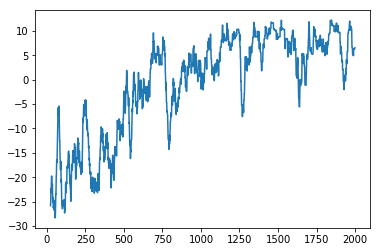

In [0]:
# Displaying the learning (in terms of reward)

df = pd.DataFrame(rewards,columns=['r'])
rolling_mean = df['r'].rolling(window=25).mean()
plt.plot(rolling_mean)

In [0]:
# Sample Episode

state = env.reset()
print('AI:\tx\nRandom:\to')
print('Note that the AI can "waste" a turn, but it is punished for doing so.')
print('\nAI\'s reward: '  + str(evaluateEpisode(state, True)))

AI:	x
Random:	o
Note that the AI can "waste" a turn, but it is punished for doing so.


 | | 
-----
 | | 
-----
 | | 


o| | 
-----
x| | 
-----
 | | 


o|o| 
-----
x|x| 
-----
 | | 


o|o| 
-----
x|x|x
-----
 | |o

AI's reward: 13
